In [1]:
# Cell 1: Imports
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from scipy.optimize import differential_evolution
import time
import matplotlib.pyplot as plt
import sys
sys.path.append('../') # This allows us to import from the parent directory
from core_framework.model import OSELM, AdaptiveEnsemble

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Cell 2: Data Loading and Preparation
def create_dataset(data, look_back=10):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back)])
        y.append(data[i + look_back])
    return np.array(X), np.array(y)

ticker = "AAPL"
data = yf.download(ticker, start="2020-01-01", end="2023-12-31")
price_data = data['Close'].values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_price_data = scaler.fit_transform(price_data)

look_back = 10
X, y = create_dataset(scaled_price_data.flatten(), look_back)

initial_train_size = 100
X_initial_train, y_initial_train = X[:initial_train_size], y[:initial_train_size]
X_online, y_online = X[initial_train_size:], y[initial_train_size:]

print(f"Shape of initial training data (X): {X_initial_train.shape}")
print(f"Shape of online simulation data (X): {X_online.shape}")

C:\Users\ASUS-PLUS\AppData\Local\Temp\ipykernel_23828\2291652971.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2020-01-01", end="2023-12-31")
[*********************100%***********************]  1 of 1 completed

Shape of initial training data (X): (100, 10)
Shape of online simulation data (X): (896, 10)


In [10]:
# Cell 3: Definition of the Dual-Objective Fitness Function
THETA = 0.7

def fitness_function(hyperparams):
    n_learners = int(hyperparams[0])
    window_size = int(hyperparams[1])
    n_hidden = int(hyperparams[2])
    C = hyperparams[3]
    alpha = hyperparams[4]

    model = AdaptiveEnsemble(
        n_learners=n_learners,
        window_size=window_size,
        n_hidden=n_hidden,
        C=C,
        alpha=alpha
    )

    start_time = time.time()
    model.fit(X_initial_train, y_initial_train)
    end_time = time.time()
    training_time = end_time - start_time
    f_speed = training_time

    predictions = model.predict(X_initial_train)
    rmse_error = np.sqrt(np.mean((predictions - y_initial_train)**2))
    f_accuracy = rmse_error
    
    final_fitness_score = (THETA * f_accuracy) + ((1 - THETA) * f_speed)

    print(f"Params: [Learners:{n_learners}, Win:{window_size}, Hidden:{n_hidden}] -> Fitness: {final_fitness_score:.4f} (RMSE:{rmse_error:.4f}, Time:{training_time:.4f}s)")
    
    return final_fitness_score

In [11]:
# Cell 4: Running the Optimization Process with DE
bounds = [
    (5, 20),      # Number of learners
    (10, 50),     # Window size
    (10, 100),    # Number of hidden neurons
    (1e-4, 1e4),  # Regularization coefficient (C)
    (0.1, 0.9)    # Trust sensitivity (alpha)
]

print("Starting Differential Evolution optimization...")
print("-" * 50)

result = differential_evolution(
    func=fitness_function, 
    bounds=bounds,
    maxiter=5,
    popsize=10,
    updating='immediate',
    disp=True
)

print("-" * 50)
print("Optimization finished!")
print("\nBest hyperparameters found:")
print(result.x)

best_hyperparams = result.x

Starting Differential Evolution optimization...
--------------------------------------------------
Params: [Learners:12, Win:13, Hidden:51] -> Fitness: 0.0137 (RMSE:0.0138, Time:0.0134s)
Params: [Learners:7, Win:46, Hidden:68] -> Fitness: 0.0110 (RMSE:0.0138, Time:0.0044s)
Params: [Learners:9, Win:11, Hidden:52] -> Fitness: 0.0108 (RMSE:0.0138, Time:0.0037s)
Params: [Learners:15, Win:49, Hidden:29] -> Fitness: 0.0109 (RMSE:0.0140, Time:0.0036s)
Params: [Learners:11, Win:14, Hidden:66] -> Fitness: 0.0109 (RMSE:0.0138, Time:0.0042s)
Params: [Learners:12, Win:15, Hidden:14] -> Fitness: 0.0109 (RMSE:0.0140, Time:0.0036s)
Params: [Learners:8, Win:38, Hidden:76] -> Fitness: 0.0119 (RMSE:0.0139, Time:0.0071s)
Params: [Learners:17, Win:23, Hidden:86] -> Fitness: 0.0129 (RMSE:0.0137, Time:0.0111s)
Params: [Learners:16, Win:11, Hidden:65] -> Fitness: 0.0123 (RMSE:0.0138, Time:0.0088s)
Params: [Learners:17, Win:25, Hidden:25] -> Fitness: 0.0097 (RMSE:0.0139, Time:0.0000s)
Params: [Learners:13, Wi

--- Running Final Simulation with Best Parameters ---
Learners: 7, Window: 38, Hidden Neurons: 68
Initial training complete.
Starting online simulation...
Online simulation finished.


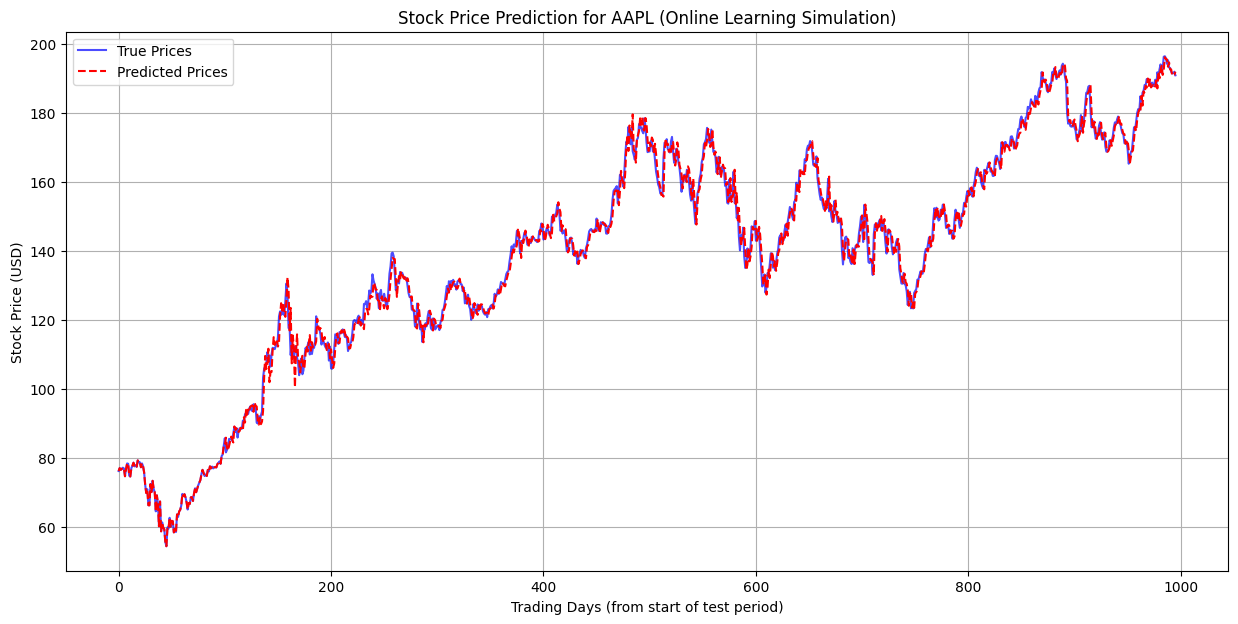


Final RMSE on the online test set (in USD): $2.85


In [12]:
# Cell 5: Final Simulation and Plotting Results
best_n_learners = int(best_hyperparams[0])
best_window_size = int(best_hyperparams[1])
best_n_hidden = int(best_hyperparams[2])
best_C = best_hyperparams[3]
best_alpha = best_hyperparams[4]

print("--- Running Final Simulation with Best Parameters ---")
print(f"Learners: {best_n_learners}, Window: {best_window_size}, Hidden Neurons: {best_n_hidden}")

final_model = AdaptiveEnsemble(
    n_learners=best_n_learners,
    window_size=best_window_size,
    n_hidden=best_n_hidden,
    C=best_C,
    alpha=best_alpha
)

final_model.fit(X_initial_train, y_initial_train)
print("Initial training complete.")

online_predictions = []
print("Starting online simulation...")

for i in range(len(X_online)):
    current_x = X_online[i].reshape(1, -1)
    current_y = y_online[i]
    prediction = final_model.predict(current_x)
    online_predictions.append(prediction[0])
    final_model.partial_fit(current_x, np.array([current_y]))

print("Online simulation finished.")
online_predictions = np.array(online_predictions)

predicted_prices_scaled = np.concatenate([y_initial_train, online_predictions])
true_prices_scaled = np.concatenate([y_initial_train, y_online])

predicted_prices = scaler.inverse_transform(predicted_prices_scaled.reshape(-1, 1))
true_prices = scaler.inverse_transform(true_prices_scaled.reshape(-1, 1))

plt.figure(figsize=(15, 7))
plt.plot(true_prices, label='True Prices', color='blue', alpha=0.7)
plt.plot(predicted_prices, label='Predicted Prices', color='red', linestyle='--')
plt.title(f'Stock Price Prediction for {ticker} (Online Learning Simulation)')
plt.xlabel('Trading Days (from start of test period)')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

dollar_rmse = np.sqrt(np.mean((predicted_prices[-len(y_online):] - true_prices[-len(y_online):])**2))
print(f"\nFinal RMSE on the online test set (in USD): ${dollar_rmse:.2f}")